# Image classification with Neural Networks

## Machine Learning Project


\
**Group:** Andrea Ierardi, Emanuele Morales, Gregorio Luigi Saporito


## 1. The dataset

## 1.1 Libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import random
import pandas as pd 


from sklearn.datasets import load_files
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import np_utils

Using TensorFlow backend.


## 1.2 Data Loading

In [3]:
DATADIR = "dataset/fruits-360/Training"
DATADIR_test = "dataset/fruits-360/Test"

TYPES = ["Apple", "Banana", "Plum", "Pepper", "Cherry", "Grape", "Tomato", "Potato", "Pear", "Peach"]
fruits = {}
def load_dataset(dire):
    fruits = {}
    images_as_array = []
    labels =[]
    for category in tqdm(os.listdir(dire)):
        for typ in TYPES:
            if(category.split()[0] == typ):
               # print(category, typ)
                fruits[category]= typ
                path = os.path.join(dire,category)
                class_num =TYPES.index(fruits[category])

                class_name = fruits[category]
                for img in tqdm(os.listdir(path)):
                   # print("OK: ",os.path.join(path,img) )
                    file = os.path.join(path,img)
                    #print(file, " -- ", dataset)
                    images_as_array.append(img_to_array(load_img(file,target_size=(32, 32))))
                    labels.append(class_num)
    images_as_array =  np.array(images_as_array)
    labels = np.array(labels)
    return images_as_array, labels




### Split in test and training sets

In [4]:
train = load_dataset(DATADIR)
test = load_dataset(DATADIR_test)


 87%|████████▋ | 385/444 [00:30<00:04, 14.70it/s]


 83%|████████▎ | 410/492 [00:02<00:00, 173.42it/s]


 88%|████████▊ | 433/490 [00:05<00:00, 84.16it/s]


 64%|██████▍   | 317/492 [00:01<00:00, 184.91it/s]


 69%|██████▉   | 324/471 [00:04<00:03, 38.93it/s]


 22%|██▏       | 110/490 [00:03<00:25, 14.78it/s]


 92%|█████████▏| 643/702 [00:11<00:02, 27.64it/s]


  0%|          | 0/666 [00:00<?, ?it/s]


 65%|██████▍   | 291/450 [00:02<00:01, 113.01it/s]


 13%|█▎        | 49/367 [00:01<00:15, 20.71it/s]


 51%|█████     | 84/164 [00:02<00:01, 55.85it/s]


 52%|█████▏    | 127/246 [00:00<00:01, 90.65it/s]


 90%|█████████ | 148/164 [00:16<00:01, 12.26it/s]


 68%|██████▊   | 97/142 [00:00<00:00, 256.89it/s]


100%|██████████| 120/120 [01:46<00:00,  1.13it/s]


In [5]:
x_train, y_train= train

In [6]:
x_test, y_test = test

### Train and test shape

In [6]:
print('Train shape:')
print('X: ',x_train.shape)
print('y: ',y_train.shape)

print('Test shape')
print('X: ',x_test.shape)
print('y: ',y_test.shape)


Train shape:
X:  (29340, 32, 32, 3)
y:  (29340,)
Test shape
X:  (9817, 32, 32, 3)
y:  (9817,)


## 1.2 Pre-processing 

### Pre-process the labels and the images

In [7]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

no_of_classes = len(np.unique(y_train))
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test = np_utils.to_categorical(y_test,no_of_classes)


In [8]:
print(y_train[0:10])
print("Number of classes: ",no_of_classes)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Number of classes:  10


### Visualisation of the first 10 images

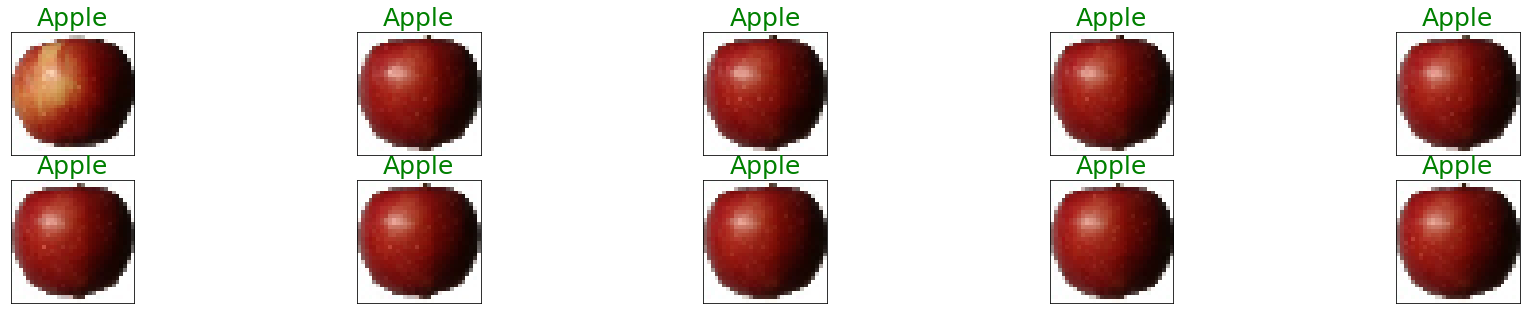

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(TYPES[np.argmax(y_train[i])]),color=("green"),fontdict= {'fontsize': '25'})

### Suffle of the data

In [10]:
from sklearn.utils import shuffle
import numpy as np
x_train,y_train = shuffle(x_train, y_train)
x_test,y_test = shuffle(x_test, y_test)

### Visualisation of the first 10 images shuffled

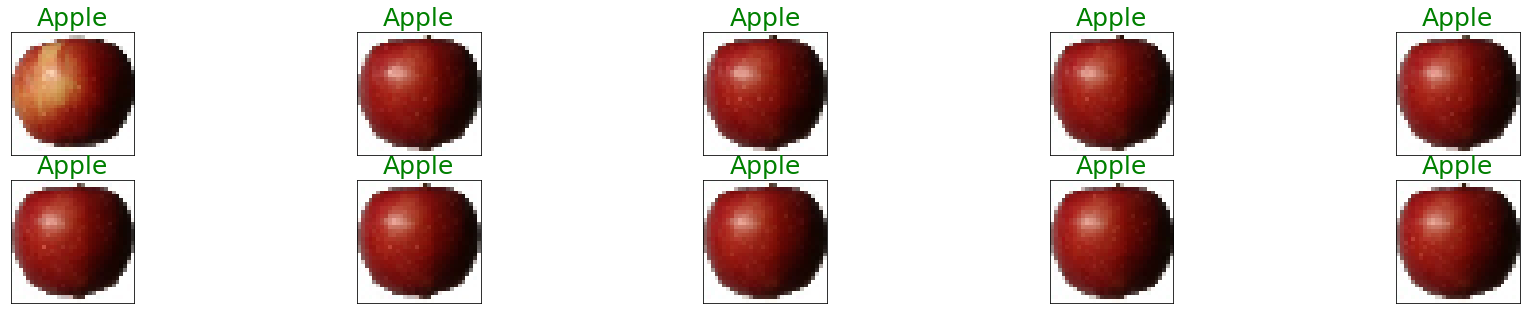

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(TYPES[np.argmax(y_train[i])]),color=("green"),fontdict= {'fontsize': '25'})

### Split in validation and test set

In [12]:
# Using 80-20 rule
split = len(x_test)*80//100

print('Test len before split: ',len(x_test))
print('Validation split len:', split)

Test len before split:  9817
Validation split len: 7853


In [13]:

# Now, we have to divide the validation set into test and validation set
x_test,x_valid = x_test[split:],x_test[:split]
y_test,y_vaild = y_test[split:],y_test[:split]
print('Train X : ',x_train.shape)
print('Train y :',y_train.shape)

print('1st training image shape ',x_train[0].shape)

print('Vaildation X : ',x_valid.shape)
print('Vaildation y :',y_vaild.shape)
print('Test X : ',x_test.shape)
print('Test y : ',y_test.shape)

Train X :  (29340, 32, 32, 3)
Train y : (29340, 10)
1st training image shape  (32, 32, 3)
Vaildation X :  (7853, 32, 32, 3)
Vaildation y : (7853, 10)
Test X :  (1964, 32, 32, 3)
Test y :  (1964, 10)




## 1.3 Convolutional Neural Newtworks

### First Approach 

In [160]:
#Simple CNN from scratch - we are using 3 Conv layers followed by maxpooling layers.
# At the end we add dropout, flatten and some fully connected layers(Dense).

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(32,32,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(10,activation = 'softmax'))
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)         

In [161]:

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')




Compiled!


In [162]:

history = model.fit(x_train,y_train,
        batch_size = 32,
        epochs=10,
        validation_data=(x_valid, y_vaild),
        verbose=2, 
     #   shuffle=True
                   )



Epoch 1/10
917/917 - 37s - loss: 0.7620 - accuracy: 0.7327 - val_loss: 0.1859 - val_accuracy: 0.9345
Epoch 2/10
917/917 - 33s - loss: 0.1162 - accuracy: 0.9614 - val_loss: 0.0981 - val_accuracy: 0.9661
Epoch 3/10
917/917 - 24s - loss: 0.0497 - accuracy: 0.9839 - val_loss: 0.0949 - val_accuracy: 0.9766
Epoch 4/10
917/917 - 25s - loss: 0.0318 - accuracy: 0.9895 - val_loss: 0.0295 - val_accuracy: 0.9885
Epoch 5/10
917/917 - 25s - loss: 0.0226 - accuracy: 0.9928 - val_loss: 0.0216 - val_accuracy: 0.9934
Epoch 6/10
917/917 - 22s - loss: 0.0182 - accuracy: 0.9946 - val_loss: 0.0260 - val_accuracy: 0.9927
Epoch 7/10
917/917 - 22s - loss: 0.0168 - accuracy: 0.9947 - val_loss: 0.0539 - val_accuracy: 0.9896
Epoch 8/10
917/917 - 25s - loss: 0.0173 - accuracy: 0.9953 - val_loss: 0.0567 - val_accuracy: 0.9931
Epoch 9/10
917/917 - 21s - loss: 0.0151 - accuracy: 0.9962 - val_loss: 0.0480 - val_accuracy: 0.9910
Epoch 10/10
917/917 - 21s - loss: 0.0149 - accuracy: 0.9958 - val_loss: 0.0207 - val_accura

In [163]:

# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])



 Test accuracy: 0.994908332824707


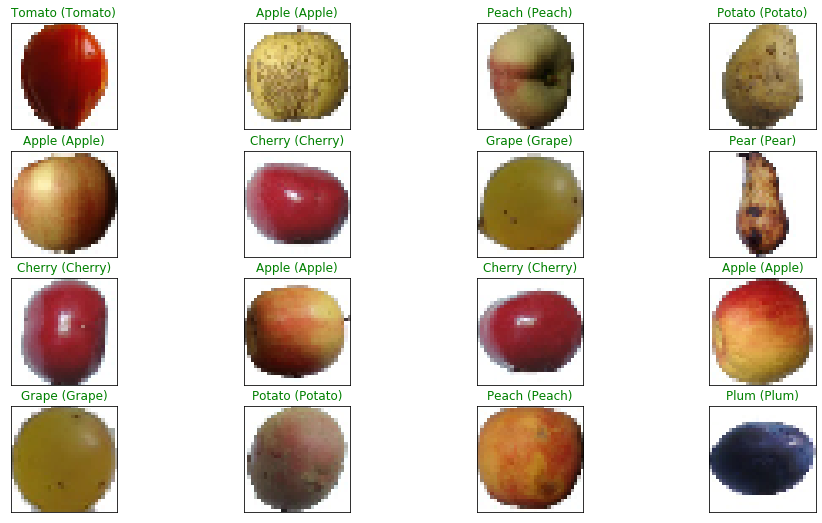

In [177]:
y_pred = model.predict(x_test)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(TYPES[pred_idx], TYPES[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
    


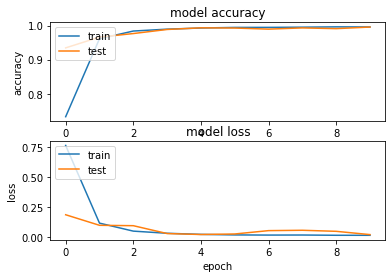

In [165]:
#Finally lets visualize the loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

### Parameters Tuning

In [ ]:
from datetime import datetime
from keras.callbacks import TensorBoard

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K
dense_layers = [0, 1, 2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "Fruits-{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, datetime.now().strftime("%d%m%Y-%H%M%S"))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, 2, input_shape=(32,32,3),padding='same'))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=2))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, 2))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=2))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(10,activation = 'softmax'))
    

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            #
            #!
            #categorical_crossentropy
            #!
            #
            model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
            print('Compiled!')
            
            history = model.fit(x_train,y_train,
        batch_size = 32,
        epochs=10,
        validation_data=(x_valid, y_vaild),
        verbose=2, 
        callbacks=[tensorboard]
        )

# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

## 1.4 MobileNetV2

In [15]:
from keras.applications import MobileNetV2

model = MobileNetV2(input_shape=(32, 32, 3), alpha=1, weights=None,classes=10)
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
print('Compiled!')

Model: "mobilenetv2_1.00_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 33, 33, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [20]:
history = model.fit(x_train,y_train,
        batch_size = 32,
        epochs=10,
        validation_data=(x_valid, y_vaild),
        verbose=2, 
     #   shuffle=True
                   )

Train on 29340 samples, validate on 7853 samples
Epoch 1/10
 - 215s - loss: 0.0809 - accuracy: 0.9821 - val_loss: 1.0141 - val_accuracy: 0.7196
Epoch 2/10
 - 201s - loss: 0.0759 - accuracy: 0.9830 - val_loss: 5.0750 - val_accuracy: 0.6615
Epoch 3/10
 - 208s - loss: 0.0577 - accuracy: 0.9863 - val_loss: 1.1330 - val_accuracy: 0.8617
Epoch 4/10
 - 212s - loss: 0.0726 - accuracy: 0.9837 - val_loss: 3.7890 - val_accuracy: 0.6906
Epoch 5/10
 - 204s - loss: 0.0326 - accuracy: 0.9927 - val_loss: 0.2813 - val_accuracy: 0.9647
Epoch 6/10
 - 202s - loss: 0.0466 - accuracy: 0.9897 - val_loss: 3.5906 - val_accuracy: 0.7155
Epoch 7/10
 - 194s - loss: 0.0268 - accuracy: 0.9939 - val_loss: 1.6591 - val_accuracy: 0.8571
Epoch 8/10
 - 224s - loss: 0.0521 - accuracy: 0.9883 - val_loss: 1.2045 - val_accuracy: 0.8902
Epoch 9/10
 - 256s - loss: 0.0203 - accuracy: 0.9956 - val_loss: 0.9463 - val_accuracy: 0.8808
Epoch 10/10
 - 246s - loss: 0.0424 - accuracy: 0.9909 - val_loss: 3.7870 - val_accuracy: 0.6920


In [21]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7041751742362976


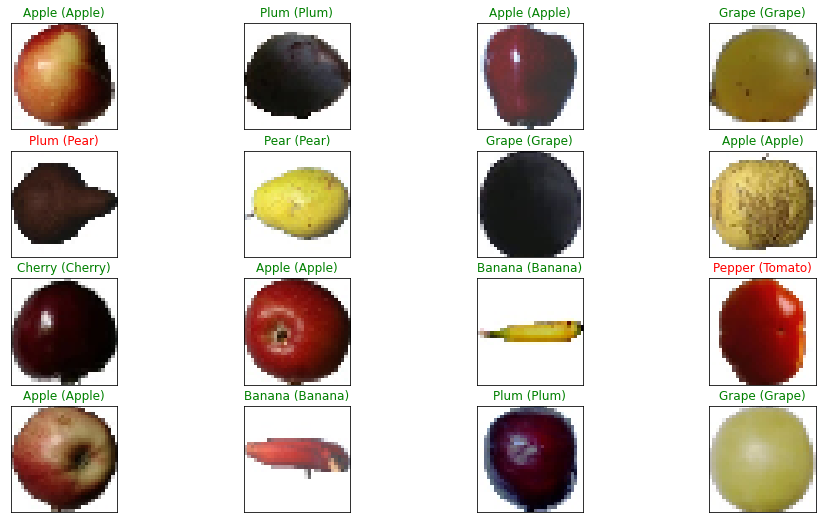

In [22]:
y_pred = model.predict(x_test)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(TYPES[pred_idx], TYPES[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

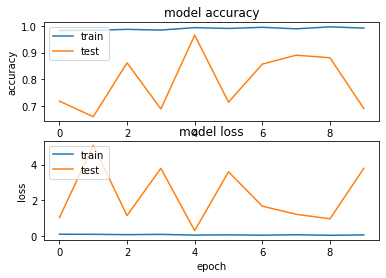

In [23]:
#Finally lets visualize the loss and accuracy wrt epochs

plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

## 1.5 LeNet Neural Networks

In [16]:
#leNet Neural Network

input_shape = (32,32,3)
num_classes = 10
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=input_shape, padding="same"),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'),
    tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation = 'tanh'),
    tf.keras.layers.Dense(84, activation = 'tanh'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 6)         456       
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

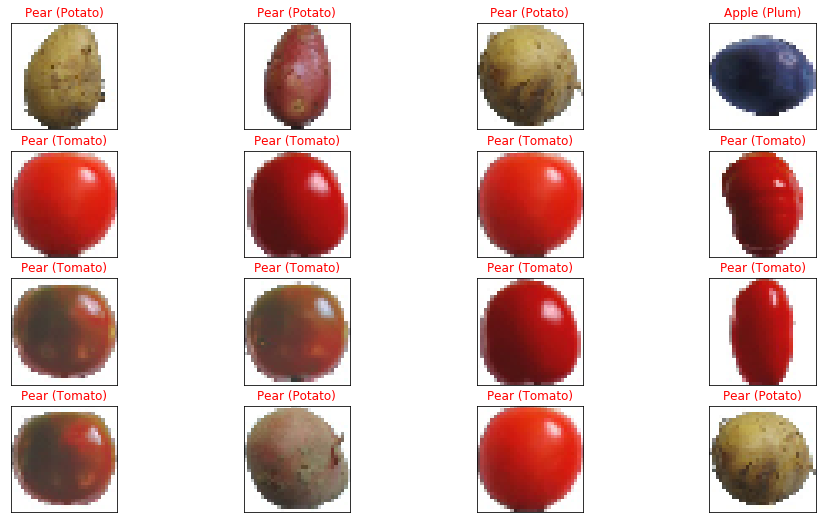

In [19]:
y_pred = model.predict(x_test)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(TYPES[pred_idx], TYPES[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [15]:
history = model.fit(x_train, y_train,
                    batch_size = 32,
                    epochs = 10,
                    validation_data=(x_valid, y_vaild),
                    verbose = 2
                    )

Train on 29340 samples, validate on 7853 samples
Epoch 1/10
29340/29340 - 38s - loss: 0.3343 - accuracy: 0.8980 - val_loss: 0.1525 - val_accuracy: 0.9539
Epoch 2/10
29340/29340 - 27s - loss: 0.0158 - accuracy: 0.9975 - val_loss: 0.1552 - val_accuracy: 0.9455
Epoch 3/10
29340/29340 - 25s - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.1409 - val_accuracy: 0.9724
Epoch 4/10
29340/29340 - 25s - loss: 6.7397e-04 - accuracy: 1.0000 - val_loss: 0.0971 - val_accuracy: 0.9763
Epoch 5/10
29340/29340 - 25s - loss: 3.2109e-04 - accuracy: 1.0000 - val_loss: 0.0978 - val_accuracy: 0.9767
Epoch 6/10
29340/29340 - 25s - loss: 1.9572e-04 - accuracy: 1.0000 - val_loss: 0.1028 - val_accuracy: 0.9762
Epoch 7/10
29340/29340 - 25s - loss: 1.2056e-04 - accuracy: 1.0000 - val_loss: 0.0974 - val_accuracy: 0.9775
Epoch 8/10
29340/29340 - 25s - loss: 7.4642e-05 - accuracy: 1.0000 - val_loss: 0.0944 - val_accuracy: 0.9777
Epoch 9/10
29340/29340 - 24s - loss: 4.6342e-05 - accuracy: 1.0000 - val_loss: 0.1038 - val

In [17]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9898167


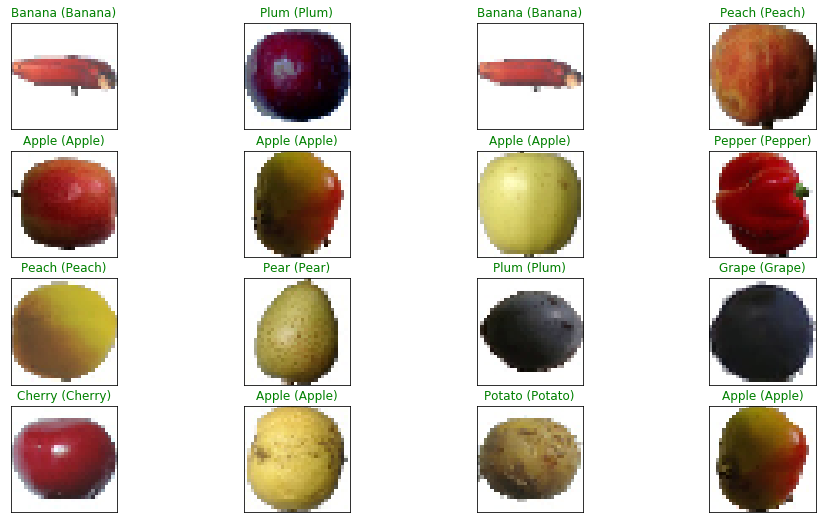

In [18]:
y_pred = model.predict(x_test)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(TYPES[pred_idx], TYPES[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

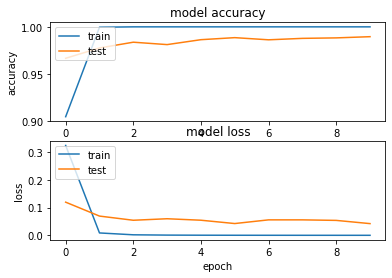

In [19]:
#plots

import matplotlib.pyplot as plt 
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()